## Context

#### Predicting Pregnancy Risk Factors Using Data Science

This project aims to leverage data science techniques to identify distinct subgroups within a population of pregnant women and assess their associated risk factors. By understanding these subgroups, healthcare providers can tailor personalised prenatal care interventions to improve maternal and fetal health outcomes.

Hypothesis: There are distinct subgroups within the population (e.g., young with high BP, older with normal BP) that have differing risk profiles.

Hierarchical Clustering is a suitable approach for this subpopulation clustering task. It allows us to group women based on similarities in their characteristics, such as age, blood pressure, and other relevant factors. This will help identify distinct risk profiles within the population.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy import stats
#from scipy.stats import chi2_contingency

## 1. Data Cleaning

In [2]:
df = pd.read_csv("Maternal Health Risk Data Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
df.shape

(1014, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [5]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


#### Insights:
- Response variable will be `RiskLevel`, the rest of the 6 features will be predictor variables.
- Data contains range of `Age` of pregnant women from 10 to 70 years old (uncommon but possible)
- Possible error with `HeartRate` having a min of 7

In [6]:
print(df.HeartRate.mode())
df.loc[df.HeartRate == 7, "HeartRate"] = 70

0    70
Name: HeartRate, dtype: int64


In [7]:
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [8]:
df[df.duplicated(keep='first')]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [9]:
df = df.drop_duplicates().reset_index(drop=True)

### Feature Encoding

In [10]:
df.RiskLevel.unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [11]:
df.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2}, inplace=True)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


## 2. Exploratory Data Analysis

### Check for Outliers

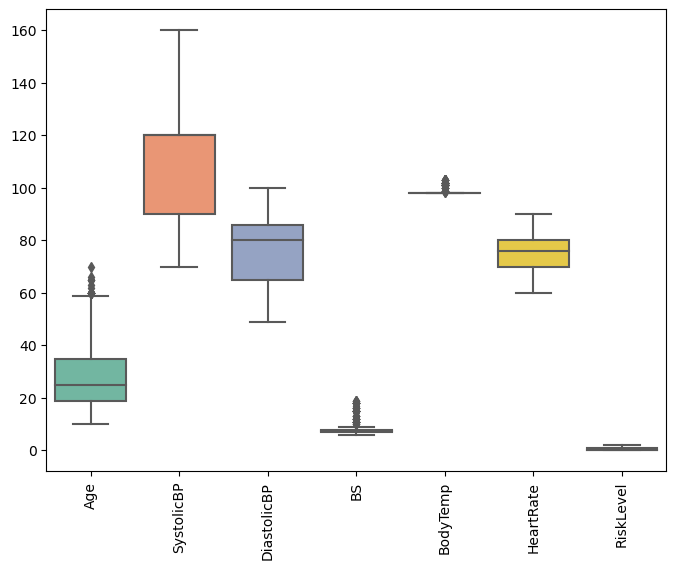

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, palette='Set2')
plt.xticks(rotation=90)
plt.show()

#### Insights: 
- As variables have different scales, might need to perform feature scaling when modelling. This ensures that certain features do not dominate others, for example features with larger scales can disproportionately influence calculations in distance-based algo like k-means clustering.

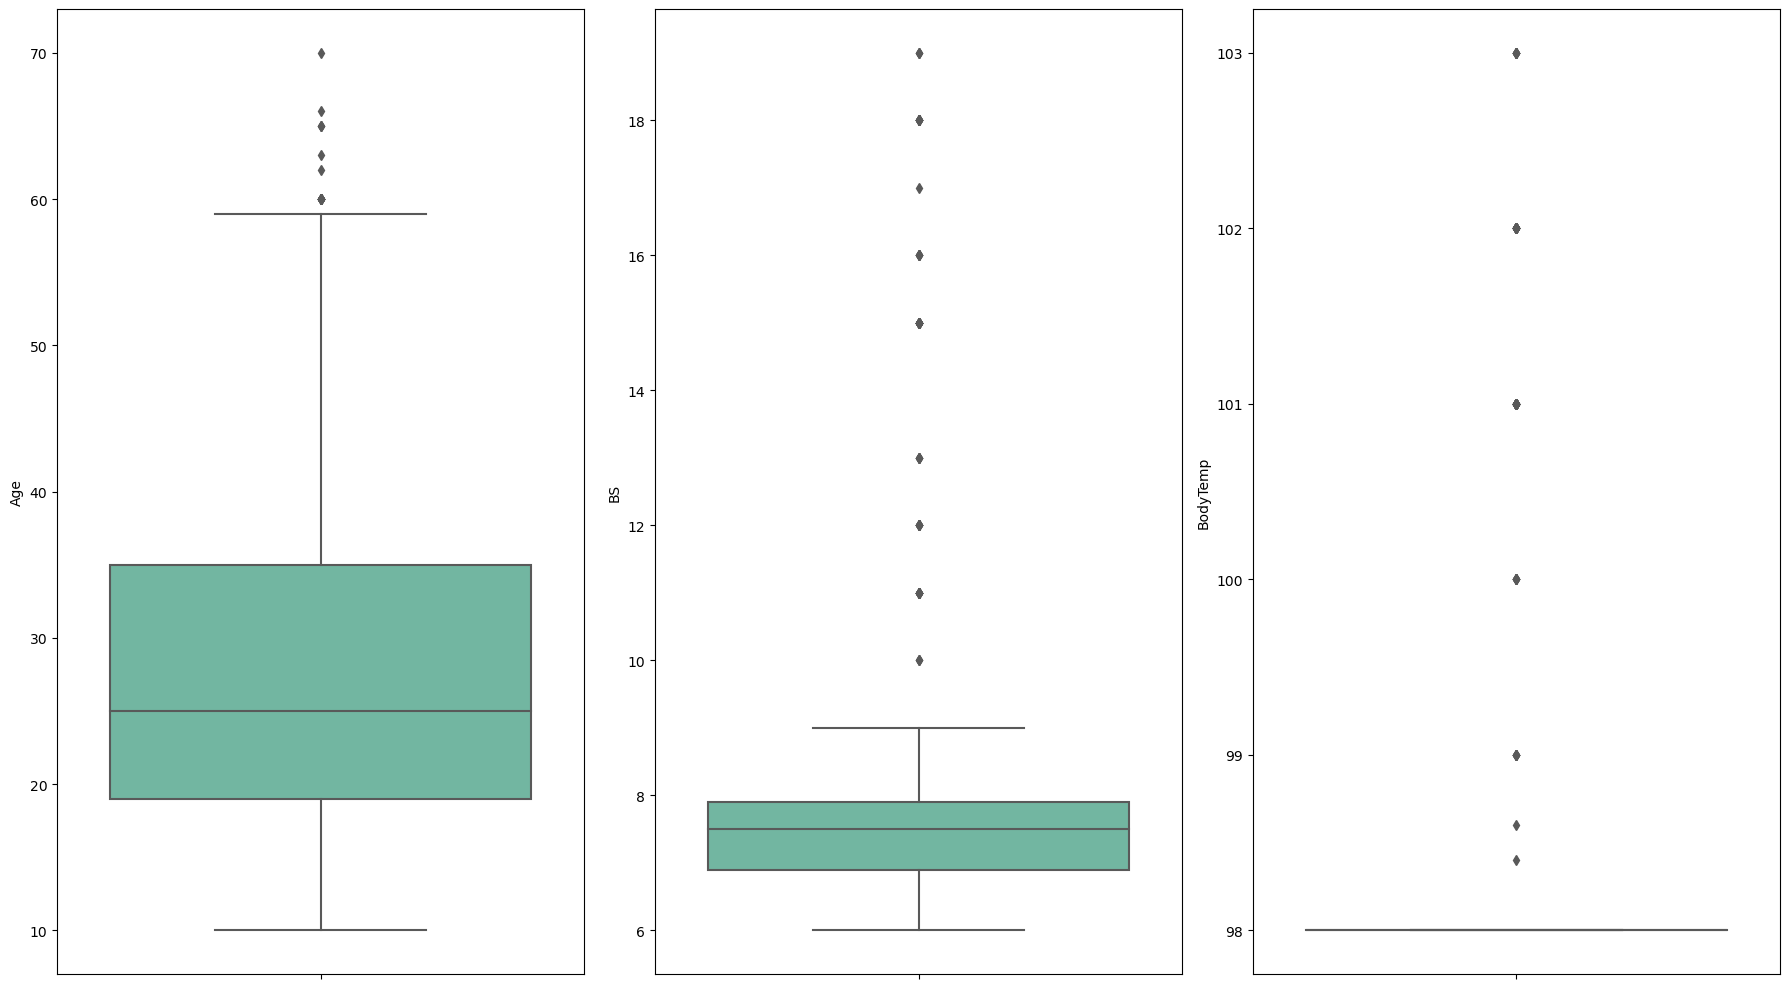

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
sns.boxplot(y='Age', data=df, palette='Set2', ax=axes[0])
sns.boxplot(y='BS', data=df, palette='Set2', ax=axes[1])
sns.boxplot(y='BodyTemp', data=df, palette='Set2', ax=axes[2])

plt.tight_layout()
plt.show()

#### Insights
- Do not remove outliers since they might reflect true biological diversity within the population. E.g. extreme values in blood pressure or glucose levels could be indicative of underlying health issues that need attention. Thus are considered true data pts.

### Univariate and Bivariate Analysis

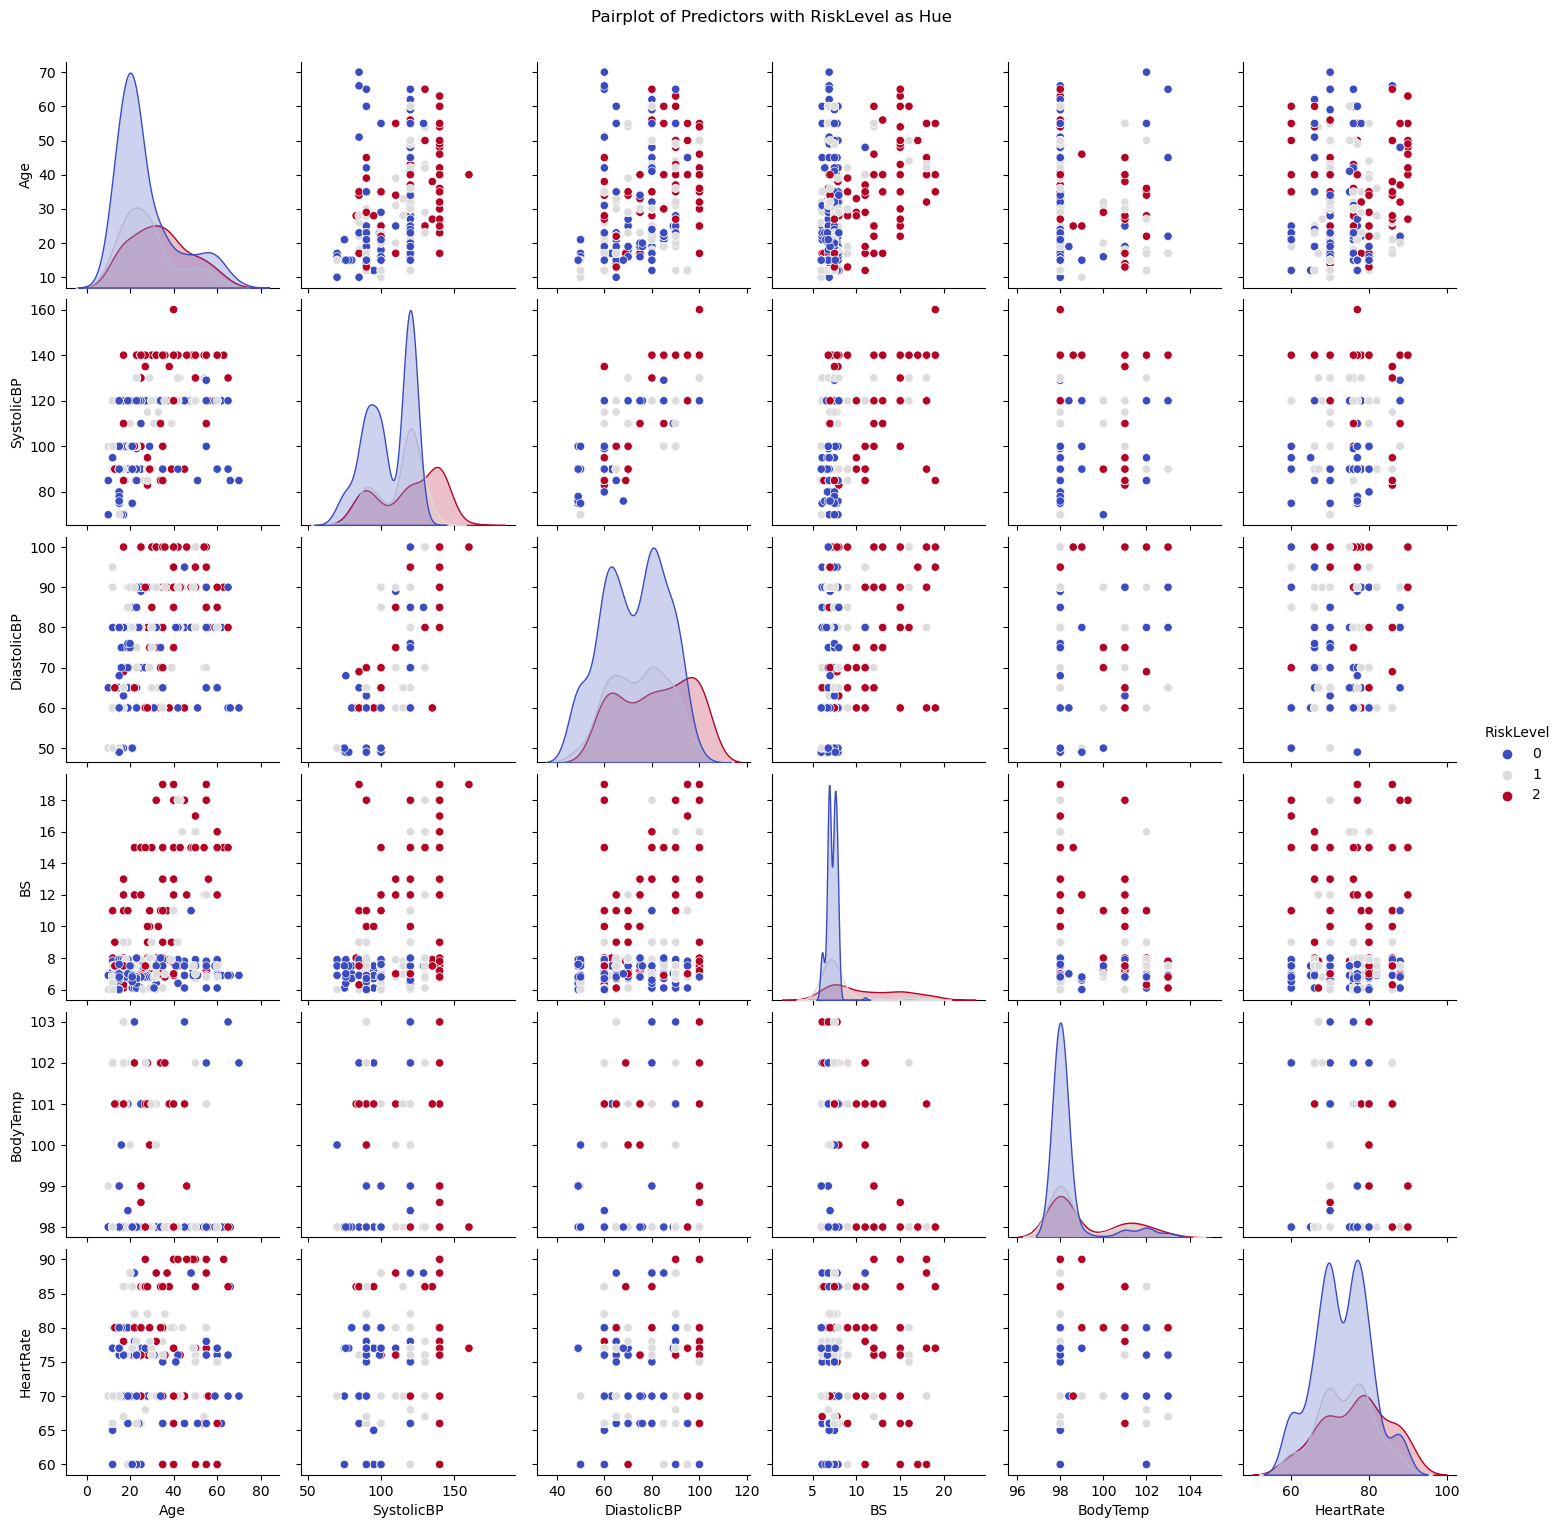

In [14]:
# Relationship between features and risk level

sns.pairplot(df, hue='RiskLevel', palette='coolwarm')
plt.suptitle('Pairplot of Predictors with RiskLevel as Hue', y=1.02)
plt.show()

#### Insights:
- **Age and Risk Level**: There seems to be a slight positive correlation between age and risk level. This suggests that older individuals might be more likely to have higher risk levels. The distribution of risk levels within each age group could provide more detailed insights - e.g. if older individuals are more evenly distributed across risk levels, it might indicate that age is a factor but not the sole determinant.

- **Systolic Blood Pressure (SBP) and Risk Level**: Higher SBP values might be associated with increased risk. Examining the distribution of SBP within each risk level could reveal if there are specific thresholds or ranges of SBP that are particularly indicative of higher risk.

- **Diastolic Blood Pressure (DBP) and Risk Level**: A similar weak positive correlation might exist between DBP and risk level. Higher DBP values could also contribute to increased risk.

- **Body Temperature (BT) and Risk Level**: There doesn't seem to be a strong correlation between BT and risk level. However, it's essential to consider the context of the data. For example, if the data is collected from individuals with specific medical conditions or during particular time periods (e.g., during a pandemic), there might be more nuanced relationships.

- **Heart Rate (HR) and Risk Level**: The relationship between HR and risk level might be more complex. While a slight positive correlation is possible, it's also conceivable that very high or very low HR values could be associated with increased risk. Examining the distribution of HR within each risk level would provide a clearer picture of the relationship.

- Interactions: The relationships between risk level and the other features could be influenced by interactions with each other. For instance, the effect of SBP on risk level might be different for individuals with high or low HR. To fully understand the complex interplay between these features and risk level, employ multivariate analysis techniques.

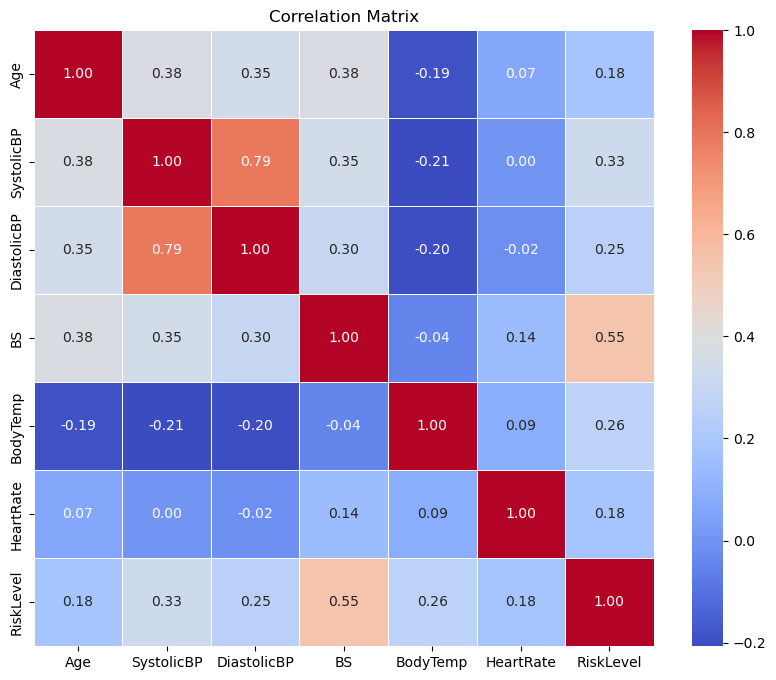

In [15]:
# Identify the relationships between variables

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Insights

**Strong Positive Correlations:**
- `SystolicBP` and `DiastolicBP`: These two variables have a very strong positive correlation of 0.79, indicating that they are highly correlated. This is expected as both are measures of blood pressure.
- `RiskLevel` and `BS`: Blood sugar is moderately positively correlated with risk level (0.55), indicating a potential link between blood sugar control and risk.

**Moderate Positive Correlations:**
- `Age` and `SystolicBP`: There is a moderately strong positive correlation between age and systolic blood pressure (0.38), suggesting that as age increases, so does systolic blood pressure.
- `Age` and `DiastolicBP`: A similar correlation exists between age and diastolic blood pressure (0.35), indicating a general trend of increasing diastolic blood pressure with age.
- `RiskLevel` and `SystolicBP`: Risk level is moderately positively correlated with systolic blood pressure (0.33), suggesting that higher systolic blood pressure might be associated with increased risk.
- `RiskLevel` and `DiastolicBP`: A similar correlation exists between risk level and diastolic blood pressure (0.25).

**Weak or No Correlations:**
- `BodyTemp` and other variables: Body temperature shows weak or no correlations with the other variables, suggesting it might not be a significant factor in determining risk level or the other variables.
- `HeartRate` and other variables: Heart rate also has weak or no correlations with the other variables, indicating it might not be a strong predictor or correlate of the other factors.

### Analysis of individual features

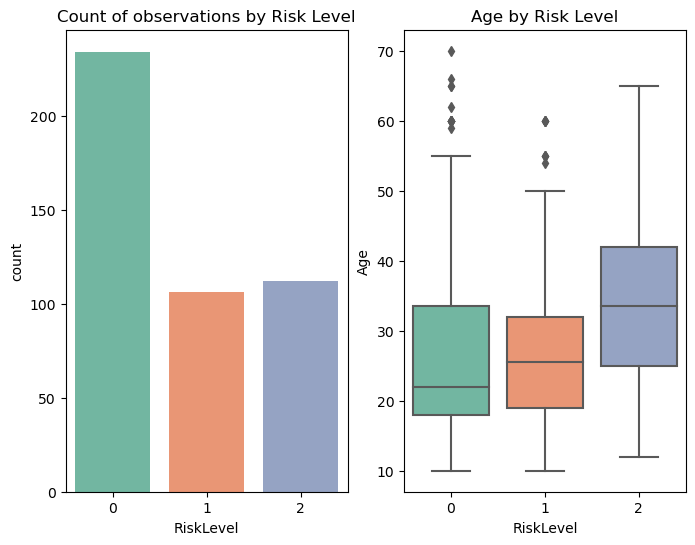

In [16]:
# Feature: Age

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8,6))
sns.countplot(ax=axes[0], x=df.RiskLevel, palette='Set2')
axes[0].set_title("Count of observations by Risk Level")

sns.boxplot(ax=axes[1], x=df.RiskLevel, y=df.Age, palette='Set2')
axes[1].set_title("Age by Risk Level");

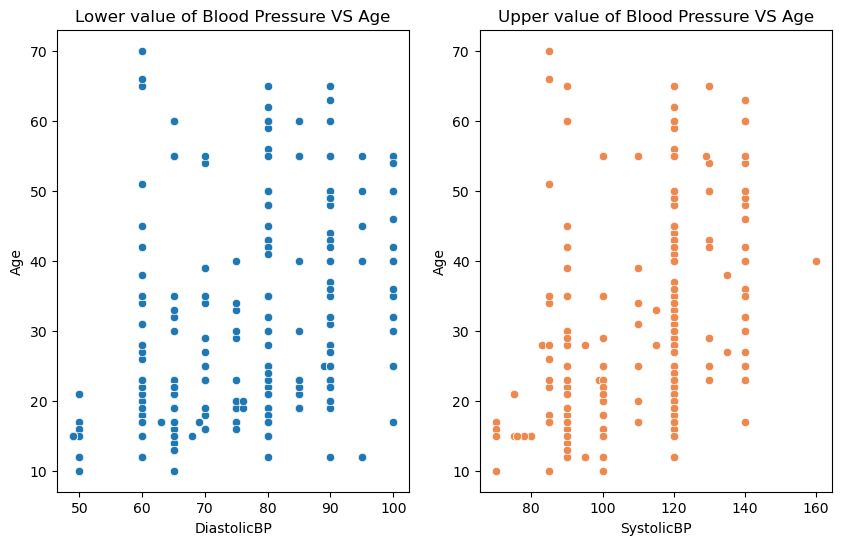

In [17]:
# Feature: Blood Pressure

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,6))

sns.scatterplot(x=df.DiastolicBP, y=df.Age, ax=axes[0], palette='Set2')
axes[0].set_title("Lower value of Blood Pressure VS Age")

sns.scatterplot(ax=axes[1], x=df.SystolicBP, y=df.Age, color="#ed894e")
axes[1].set_title("Upper value of Blood Pressure VS Age");

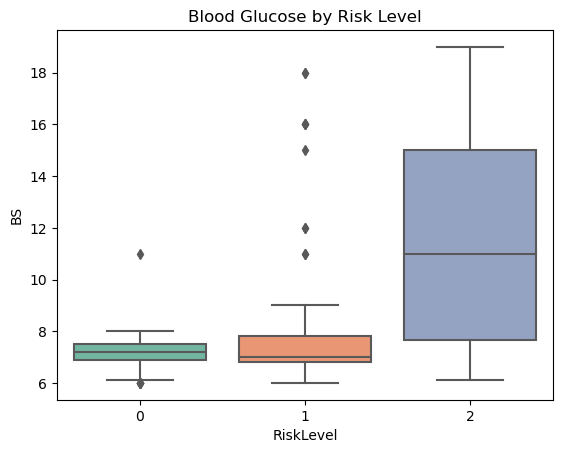

In [18]:
# Feature: BS

sns.boxplot(x=df.RiskLevel, y=df.BS, palette='Set2').set_title("Blood Glucose by Risk Level");

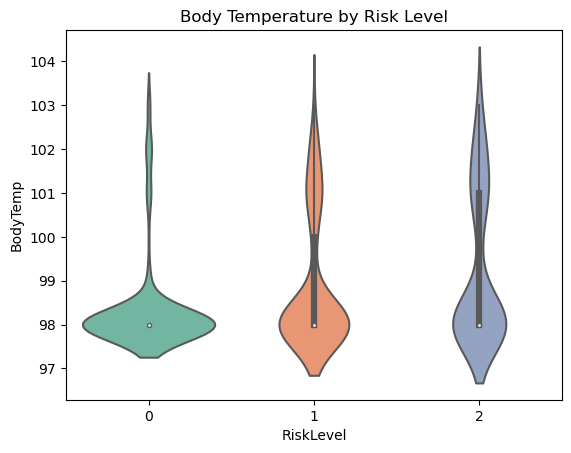

In [19]:
# Feature: Body Temp

sns.violinplot(y=df.BodyTemp, x=df.RiskLevel, palette='Set2').set_title("Body Temperature by Risk Level");

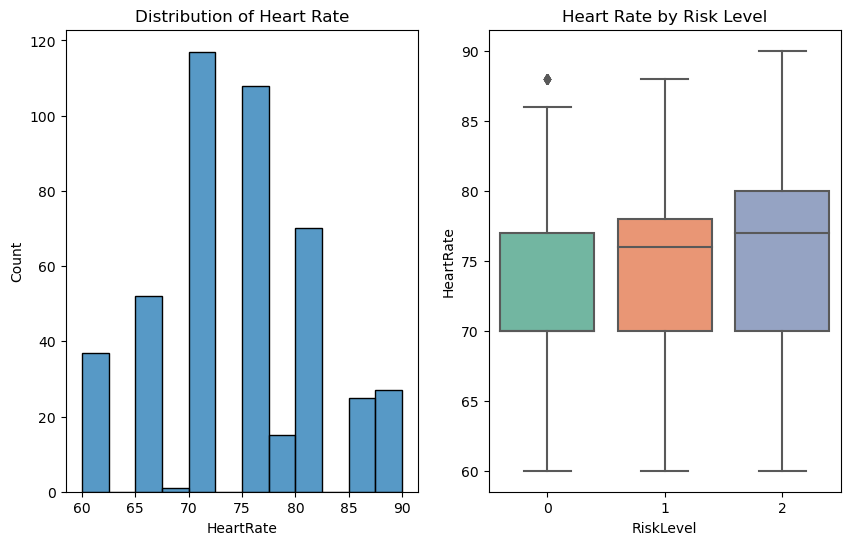

In [20]:
# Feature: Heart Rate

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,6))

sns.histplot(ax=axes[0], x=df.HeartRate, palette='Set2')
axes[0].set_title("Distribution of Heart Rate")

sns.boxplot(ax=axes[1], x=df.RiskLevel, y=df.HeartRate, palette='Set2')
axes[1].set_title("Heart Rate by Risk Level");

### Insights
- More frequent cases of low risk pregnancies across the data set
- Pregnancies of women above 35 years old are often classified as high risk.
- If a pregnant woman has a blood sugar higher than 8 mmol/L, the pregnancy is likely considered high risk.
- Higher BP (systolic and diastolic), higher body temperature are associated with higher risk pregnancies.
- Heart rate of pregnant women is normally distributed and it's only weakly associated with risk level.

## 3. Data Preprocessing

### Feature Scaling

In [21]:
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

print(df.head())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled = pd.concat([df_scaled, y], axis=1)
df_scaled.head()

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86          2
1   35         140           90  13.0      98.0         70          2
2   29          90           70   8.0     100.0         80          2
3   30         140           85   7.0      98.0         70          2
4   35         120           60   6.1      98.0         76          0


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,-0.305021,1.089310,0.333484,2.354439,-0.491351,1.584855,2
1,0.422139,1.649455,1.061321,1.646744,-0.491351,-0.543984,2
2,-0.014157,-1.151273,-0.394352,-0.122492,0.927758,0.786540,2
3,0.058559,1.649455,0.697402,-0.476340,-0.491351,-0.543984,2
4,0.422139,0.529164,-1.122188,-0.794802,-0.491351,0.254330,0


## 4. Machine Learning Modelling
**Hypothesis: There are distinct subgroups within the population (e.g., young with high BP, older with normal BP) that have differing risk profiles.**

Given the nature of the data and the goal of subpopulation clustering, the most appropriate machine learning model would be Hierarchical Clustering.

This unsupervised learning technique is well-suited for identifying distinct subgroups within a population, especially when there is no pre-defined number of clusters. By analyzing the dendrogram generated, natural groupings based on similarities can be visually identified.

Hierarchical clustering algorithms (e.g. Ward's method or complete linkage) can be used to construct the dendrogram. By cutting the dendrogram at a specific threshold, this determines the optimal number of clusters. This approach uncovers hidden patterns and relationships within the data, potentially revealing subgroups that may have different risk profiles.

Cophenetic Correlation Coefficient: 0.6789


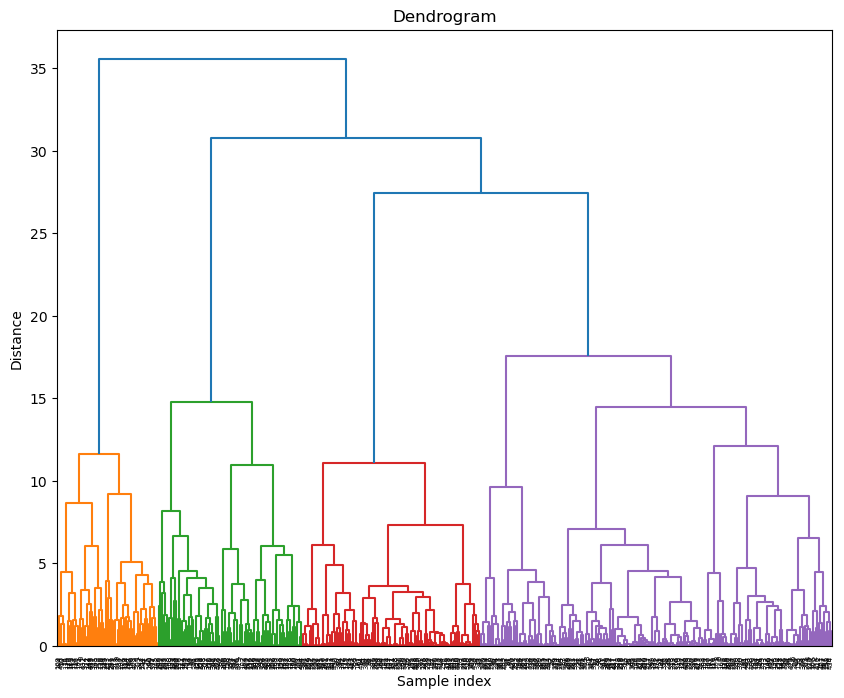

In [22]:
# Perform hierarchical clustering using a linkage method (e.g., 'ward')
Z = linkage(df_scaled, method='ward')

# Calculate the cophenetic correlation coefficient
c, coph_dists = cophenet(Z, pdist(df_scaled))

print(f'Cophenetic Correlation Coefficient: {c:.4f}')

# Data Visualisation to determine the optimal number of clusters
plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

### Insights
<u> Evaluation of dendrogram: 
- Cophenetic correlation coefficient determines how well the hierarchical clustering dendrogram reflects the pairwise distances between the original data points. 
- The relatively High CCC of 0.6789 (close to 1) indicates good agreement between the distances in the dendrogram and the original data. Thus clustering accurately captured the inherent structure of the data.  
    
<u> Determining cluster profiles:
- Several clusters are formed at various levels of similarity. By cutting the dendrogram at a specific height, number of significant clusters can be determined. Visual observation reveals the horizontal lines are more prominent around a height of 15, indicating significant differences between 5 distinct clusters.
- Analyse the clusters' profiles by comparing the mean values of the data points within each cluster.

In [23]:
threshold = 15 # Choose a height to cut the dendrogram and derive the cluster labels
main_clusters = fcluster(Z, threshold, criterion='distance')

df['MainCluster'] = main_clusters

main_cluster_profiles = df.groupby('MainCluster').mean()

print("Profiles of the Main Clusters:")
print(main_cluster_profiles.to_string(formatters={'Age': '{:.0f}'.format, 
                                         'SystolicBP': '{:.2f}'.format,
                                         'DiastolicBP': '{:.2f}'.format,
                                         'BS': '{:.2f}'.format,
                                         'BodyTemp': '{:.2f}'.format,
                                         'HeartRate': '{:.2f}'.format})) 

Profiles of the Main Clusters:
            Age SystolicBP DiastolicBP    BS BodyTemp HeartRate  RiskLevel
MainCluster                                                               
1            45     127.86       86.86 14.62    98.09     78.03   1.745763
2            24     103.67       70.04  8.00   101.51     75.70   1.190476
3            21      91.18       60.58  7.05    98.07     73.79   0.163462
4            53     113.26       79.13  7.28    98.00     72.00   0.282609
5            25     119.65       82.65  7.36    98.03     72.57   0.610063


### Insights
    
<u> Distinct subgroups identified that have differing risk profiles:
    
*Arranged in order of descending risk severity*

**Cluster 1: Middle-Aged with Elevated Blood Pressure**
- Age: 45 (middle-aged)
- SystolicBP: 127.86 (above normal)
- DiastolicBP: 86.86 (slightly elevated)
- BS: 14.62 (above normal)
- RiskLevel: 1.745763 (relatively high)
- Interpretation: This cluster suggests a group of middle-aged individuals with elevated blood pressure, potentially indicating a higher risk of cardiovascular diseases.

**Cluster 2: Younger Individuals with Extremely High Blood Pressure**
- Age: 24 (young)
- SystolicBP: 183.67 (very high)
- DiastolicBP: 70.04 (slightly elevated)
- BS: 8.00 (normal)
- RiskLevel: 1.190476 (high)
- Interpretation: This cluster identifies a group of younger individuals with extremely high systolic blood pressure, suggesting a significant risk of cardiovascular problems.

**Cluster 5: Middle-Aged Individuals with Slightly Elevated Blood Pressure**
- Age: 25 (young)
- SystolicBP: 119.65 (slightly elevated)
- DiastolicBP: 82.65 (slightly elevated)
- BS: 7.36 (normal)
- RiskLevel: 0.610063 (moderate)
- Interpretation: This cluster identifies a group of young individuals with slightly elevated blood pressure, potentially indicating a moderate risk.
    
**Cluster 4: Older Individuals with Moderate Blood Pressure**
- Age: 53 (older)
- SystolicBP: 113.26 (slightly elevated)
- DiastolicBP: 79.13 (slightly elevated)
- BS: 7.28 (normal)
- RiskLevel: 0.282609 (low)
- Interpretation: This cluster suggests a group of older individuals with moderately elevated blood pressure, which might still warrant monitoring but may not pose as high a risk as the other clusters.
    
**Cluster 3: Youngest Individuals with Low Blood Pressure**
- Age: 21 (youngest)
- SystolicBP: 91.18 (low)
- DiastolicBP: 60.58 (low)
- BS: 7.05 (normal)
- RiskLevel: 0.163462 (very low)
- Interpretation: This cluster represents a group of young individuals with low blood pressure, potentially indicating a lower risk of cardiovascular issues.
<br>
    
*BS and BodyTemp are likely to  be insignificant risk factors given that the values are consistently normal across all the clusters.*

## 5. Hypothesis testing

To statistically validate the model's finding by examining whether there is a significant association between the categorical variables beyond what the machine learning model predicted, use chi-square test. 
 
*Investigate whether women who are 45 years old and older, and have elevated blood pressure, have higher pregnancy risk level. Stage 1 high blood pressure is when systolic is around 120 and above, and when diastolic is 80 and above.*

Let 𝜇1 be the population mean for pregnancy risk level for women under 45 years old with normal blood pressure and 𝜇2 be the population mean for risk level for women equal or over 45 years old with elevated blood pressure. Let α=0.05.

Null and alternative hypothesis: <br>
- H0:μ1−μ2=0  
The null hypothesis states that there is no difference in the means of the two groups.

- HA:μ1−μ2!=0 <br>
The alternative hypothesis suggests that there is a difference in the means of the two groups.

In [24]:
group1 = df.loc[(df.Age < 45) & (df.SystolicBP < 119) & (df.DiastolicBP < 80)]
group2 = df.loc[(df.Age >= 45) & (df.SystolicBP >= 119) & (df.DiastolicBP >= 80)]

group1_risk = group1['RiskLevel']
group2_risk = group2['RiskLevel']

In [25]:
t_statistic, p_value = stats.ttest_ind(group1_risk, group2_risk)
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two groups.")

T-statistic: -3.0172238456154994
P-value: 0.0028514836434068423
Reject the null hypothesis: There is a significant difference between the two groups.


### Insights
- There is a statistically significant difference between the two groups. This suggests that the risk levels of pregnancy are significantly different between the two subgroups compared. 
- The P-value is much lower than the 5% significance level. Thus, reject the hypothesis that the risk level of pregnancy does not depend on age and blood pressure of a woman. Therefore, the risk level is different depending on age and blood pressure, whereby women over 45 with elevated blood pressures have higher pregnancy risk level.
- Specifically, the negative t-statistic indicates that the first group (women in their 20s with normal blood pressure) has a lower mean pregnancy risk level compared to the second group (women over 45 with high blood pressure).

## 6. Conclusion

<u> The clustering analysis revealed several key insights:

- Subpopulation Identification: The analysis supports the hypothesis - distinct subgroups within the population were identified primarily based on age and blood pressure levels. These subgroups exhibit varying risk levels, suggesting that age and blood pressure are important factors to consider in assessing cardiovascular risk. These findings suggest that risk factors for pregnant women are not homogeneous and that personalized approaches are necessary.

- Risk Factor Significance: Features such as blood pressure, blood sugar, and age were found to be significant determinants of risk levels. These features should be prioritized in routine health assessments to flag high-risk pregnancies early.

- Healthcare Implications: The ability to classify pregnant women into distinct risk groups allows for more targeted healthcare interventions. For example, women identified in higher-risk clusters can be monitored more closely and receive specialized care to prevent complications.

<u> Further analysis could explore:

- Several challenges were encountered during the project, including the potential for multicollinearity among features and the need for careful selection of clustering cut-offs. Additionally, while the chi square test provided a good indication of cluster quality, further validation with external datasets would strengthen the findings.
- Model Improvement: Experimenting with more sophisticated models like ensemble methods or deep learning could enhance the accuracy of risk classification.
- Feature Engineering: Additional features, such as lifestyle factors, genetic information, or previous pregnancy history, could be incorporated to improve the model’s predictive power.
- Intervention strategies: Developing targeted interventions based on the specific characteristics of each cluster to improve health outcomes.
- Real-world Application: Collaborating with healthcare professionals to integrate the model into clinical settings, providing real-time risk assessments for pregnant women.